# Base vs Quasi-Random Inverse Transform Sampling (Exponential)

This notebook compares the standard inverse transform sampler (`BaseInverseTransformSampler` via `InverseTransformSampler`) with the quasi-random variant (`QuasiRandomInverseTransformSampler`) on an exponential distribution using the analytical inverse CDF.

We measure statistical accuracy and variance/convergence behavior.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from mc_lab.inverse_transform import (
    InverseTransformSampler,
    QuasiRandomInverseTransformSampler,
)

# Given inverse CDF for exponential distribution
# F^{-1}(u) = -ln(1-u)/lambda


def exponential_inverse_cdf(u, lam):
    """Inverse CDF of exponential distribution: F^(-1)(u) = -ln(1-u)/λ"""
    return -np.log(1 - u) / lam


lam = 2.0  # rate parameter (mean = 1/lam)

base_sampler = InverseTransformSampler(
    inverse_cdf=lambda u: exponential_inverse_cdf(u, lam),
    random_state=42,
)
quasi_sampler = QuasiRandomInverseTransformSampler(
    base_sampler=base_sampler,
    sequence_type="sobol",
    random_state=42,
)

lam, base_sampler, quasi_sampler

(2.0,
 <mc_lab.inverse_transform.QuasiRandomInverseTransformSampler at 0x7ef905e8f9b0>)

In [ ]:
n = 50_000

samples_base = base_sampler.sample(n)
samples_quasi = quasi_sampler.sample(n)

expected_mean = 1.0 / lam
expected_var = 1.0 / (lam**2)

summary = {
    "expected_mean": expected_mean,
    "expected_var": expected_var,
    "base_mean": float(np.mean(samples_base)),
    "base_var": float(np.var(samples_base, ddof=1)),
    "quasi_mean": float(np.mean(samples_quasi)),
    "quasi_var": float(np.var(samples_quasi, ddof=1)),
}
summary

/home/carstenj/dev/mc-lab/src/mc_lab/inverse_transform.py:395: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  return sampler.random(n).flatten()


{'expected_mean': 0.5,
 'expected_var': 0.25,
 'base_mean': 0.4980582606360891,
 'base_var': 0.24835703206167695,
 'quasi_mean': 0.5000214055165197,
 'quasi_var': 0.25015534759651215}

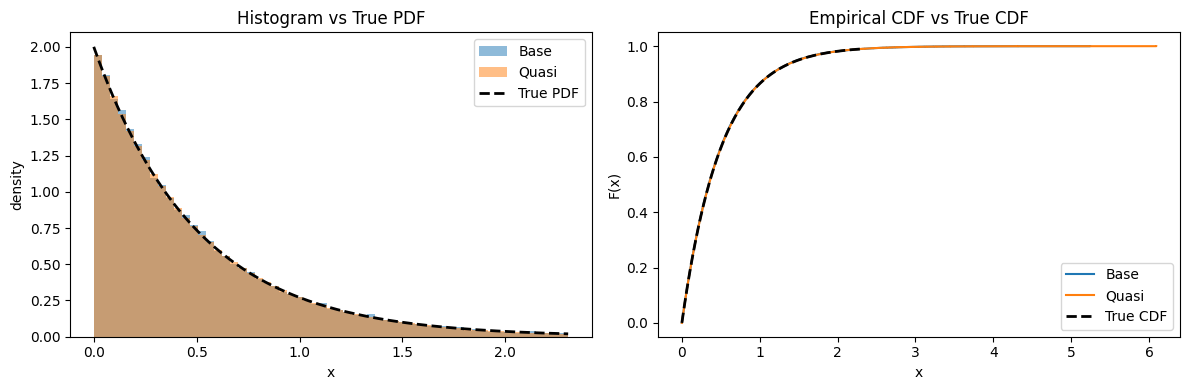

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Histogram comparison
bins = np.linspace(
    0, np.quantile(np.concatenate([samples_base, samples_quasi]), 0.99), 60
)
axs[0].hist(samples_base, bins=bins, density=True, alpha=0.5, label="Base")
axs[0].hist(samples_quasi, bins=bins, density=True, alpha=0.5, label="Quasi")

# True PDF for reference: f(x) = lam * exp(-lam x)
x_plot = np.linspace(0, bins[-1], 200)
axs[0].plot(x_plot, lam * np.exp(-lam * x_plot), "k--", lw=2, label="True PDF")
axs[0].set_title("Histogram vs True PDF")
axs[0].set_xlabel("x")
axs[0].set_ylabel("density")
axs[0].legend()

# Empirical CDF comparison
for data, label in [(samples_base, "Base"), (samples_quasi, "Quasi")]:
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    axs[1].step(x, y, where="post", label=label)

# True CDF: F(x) = 1 - exp(-lam x)
axs[1].plot(x_plot, 1 - np.exp(-lam * x_plot), "k--", lw=2, label="True CDF")
axs[1].set_title("Empirical CDF vs True CDF")
axs[1].set_xlabel("x")
axs[1].set_ylabel("F(x)")
axs[1].legend()

plt.tight_layout()
plt.show()

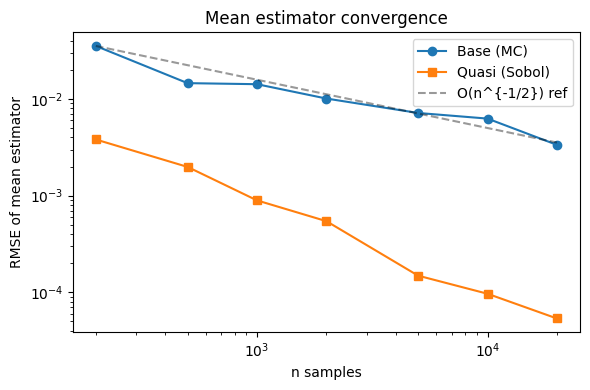

{'sizes': [200, 500, 1000, 2000, 5000, 10000, 20000],
 'rmse_base': [0.035424606335445516,
  0.01460032594533719,
  0.014238831363759818,
  0.010114863369874782,
  0.007170018756102779,
  0.006270928132046142,
  0.003352430324121083],
 'rmse_quasi': [0.003811233238997559,
  0.001981838212466755,
  0.000892566929850353,
  0.0005439603977006181,
  0.00014836353949419266,
  9.640035368011811e-05,
  5.345332298433927e-05]}

In [ ]:
# Convergence of mean estimator: RMSE vs sample size
rng = np.random.default_rng(123)

sizes = np.array([200, 500, 1_000, 2_000, 5_000, 10_000, 20_000])
reps = 20

rmse_base = []
rmse_quasi = []

for m in sizes:
    errs_base = []
    errs_quasi = []

    # For base, vary random_state per repetition; for quasi, reset sampler to ensure fresh Sobol draws
    for r in range(reps):
        # Base
        base_sampler_rs = InverseTransformSampler(
            inverse_cdf=lambda u: exponential_inverse_cdf(u, lam),
            random_state=r * 137 + 7,
        )
        x_b = base_sampler_rs.sample(m)
        errs_base.append(np.mean(x_b) - expected_mean)

        # Quasi (new quasi sampler per rep to avoid continuation effects)
        base_tmp = InverseTransformSampler(
            inverse_cdf=lambda u: exponential_inverse_cdf(u, lam),
            random_state=42,
        )
        quasi_tmp = QuasiRandomInverseTransformSampler(
            base_sampler=base_tmp,
            sequence_type="sobol",
            random_state=r * 97 + 13,
        )
        x_q = quasi_tmp.sample(m)
        errs_quasi.append(np.mean(x_q) - expected_mean)

    rmse_base.append(float(np.sqrt(np.mean(np.square(errs_base)))))
    rmse_quasi.append(float(np.sqrt(np.mean(np.square(errs_quasi)))))

rmse_base = np.array(rmse_base)
rmse_quasi = np.array(rmse_quasi)

plt.figure(figsize=(6, 4))
plt.loglog(sizes, rmse_base, "o-", label="Base (MC)")
plt.loglog(sizes, rmse_quasi, "s-", label="Quasi (Sobol)")
plt.loglog(
    sizes,
    1 / np.sqrt(sizes) * rmse_base[0] * sizes[0] ** 0.5,
    "k--",
    alpha=0.4,
    label="O(n^{-1/2}) ref",
)
plt.xlabel("n samples")
plt.ylabel("RMSE of mean estimator")
plt.title("Mean estimator convergence")
plt.legend()
plt.tight_layout()
plt.show()

{
    "sizes": sizes.tolist(),
    "rmse_base": rmse_base.tolist(),
    "rmse_quasi": rmse_quasi.tolist(),
}